# Kendrick Lamar Lyrics Generator using Markov Chains

Markov chain model to generate new lyrics in the style of Kendrick Lamar based on his existing lyrics.

In [56]:
import os
import sys
import random
import re
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

## Loading and preprocessing lyrics data

In [57]:
def load_lyrics_from_txt(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            lyrics = file.read().split('\n\n')  # Split on double newlines to separate songs
            lyrics = [lyric.strip() for lyric in lyrics if lyric.strip()]  # Remove empty entries
            return lyrics
    except Exception as e:
        print(f"Error loading text file: {e}")
        return []


txt_path = "../data/lyrics/kendrick.txt"
if os.path.exists(txt_path):
    print(f"Loading lyrics from text file: {txt_path}")
    lyrics_data = load_lyrics_from_txt(txt_path)
    print(f"Loaded {len(lyrics_data)} lyrics from text file")
else:
    print("No lyrics data found. Please provide valid file paths.")
    lyrics_data = []

Loading lyrics from text file: ../data/lyrics/kendrick.txt
Loaded 53 lyrics from text file


## Preprocessing the lyrics

In [58]:
def preprocess_lyrics(lyrics_list):
    processed_lyrics = []
    
    for lyrics in lyrics_list:
        # Convert to lowercase
        lyrics = lyrics.lower()
        
        # Remove special characters but keep sentence punctuation
        lyrics = re.sub(r'[^\w\s.,!?\()" -]+', '', lyrics)
        
        # Split into sentences
        sentences = re.split(r'(?<=[.!?])\s+', lyrics)
        
        # Filter out empty sentences
        sentences = [s.strip() for s in sentences if s.strip()]
        
        processed_lyrics.extend(sentences)
    
    return processed_lyrics


if lyrics_data:
    processed_lyrics = preprocess_lyrics(lyrics_data)
    print(f"Processed {len(processed_lyrics)} sentences from the lyrics")
else:
    print("No lyrics data found.")
    processed_lyrics = []

Processed 861 sentences from the lyrics


## Implementing the Markov Chain Model

In [59]:
class MarkovModel:
    def __init__(self, order=2):
        self.order = order
        self.model = defaultdict(list)
        self.starts = []
        
    def train(self, sentences):
        for sentence in sentences:
            words = re.findall(r'\b\w+\b|[.!?,]', sentence.lower())
            
            # ignore sentence if too short for training
            if len(words) <= self.order:
                continue 
                
            # possible starting point for sentence generation
            self.starts.append(tuple(words[:self.order]))
            
            # Build the model
            for i in range(len(words) - self.order):
                context = tuple(words[i:i+self.order])
                next_word = words[i+self.order]
                self.model[context].append(next_word)
                
    
    def generate_with_backoff(self, models, seed_words=None, max_length=50):
        if not self.model:
            return "Model has not been trained yet."
            
        # start with given seed or random start
        if seed_words and len(seed_words) >= self.order:
            current = tuple(seed_words[-self.order:])
            result = seed_words.copy()
        else:
            if not self.starts:
                return "Cannot generate text: no sentence starts found."
            current = random.choice(self.starts)
            result = list(current)
        
        # Generate words
        while len(result) < max_length:
            if current in self.model:
                next_word = random.choice(self.model[current])
            else:
                # Back off to lower orders
                found = False
                for order in range(self.order-1, 0, -1):
                    if order >= len(result) or order not in models:
                        continue
                        
                    # Try context of current order
                    shorter_context = tuple(result[-order:])
                    if shorter_context in models[order].model:
                        next_word = random.choice(models[order].model[shorter_context])
                        found = True
                        break
                
                # If no context found even after backing off, break or choose random
                if not found:
                    if len(models[1].model) > 0:  # Use order 1 model for a random word
                        random_context = random.choice(list(models[1].model.keys()))
                        next_word = random.choice(models[1].model[random_context])
                    else:
                        break
            
            result.append(next_word)
            
            # Update the context window for next iteration
            current = tuple(result[-self.order:]) if len(result) >= self.order else tuple(result)
            
            # End if we reach sentence-ending punctuation
            if next_word in ['.', '!', '?'] and len(result) > max_length // 2:
                break
                
        # Format the result nicely
        formatted = []
        for i, word in enumerate(result):
            if word in [',', '.', '!', '?']:
                if formatted:  # Check if formatted has elements
                    formatted[-1] += word # append punctuation to last word
                else:
                    formatted.append(word)
            elif i > 0 and result[i-1] not in [',', '.', '!', '?']:
                formatted.append(word)
            else:
                formatted.append(word)
                
        return ' '.join(formatted)

# Train the model with different orders
if processed_lyrics:
    # Create models with different orders
    models = {}
    for order in [1, 2, 3, 4, 5]:
        print(f"\nTraining Markov model with order {order}...")
        model = MarkovModel(order=order)
        model.train(processed_lyrics)
        models[order] = model
        print(f"Model trained with {len(model.model)} contexts")
    

    markov_model = models[1]
else:
    print("No lyrics data to train the model.")


Training Markov model with order 1...
Model trained with 6790 contexts

Training Markov model with order 2...
Model trained with 32467 contexts

Training Markov model with order 3...
Model trained with 50816 contexts

Training Markov model with order 4...
Model trained with 55562 contexts

Training Markov model with order 5...
Model trained with 56578 contexts


## Generating Lyrics

Now we can generate new lyrics using our trained Markov model!

In [60]:
def generate_lyrics(model, seed_text=None, count=5, max_length=50):
    """Generate multiple lyrics samples."""
    results = []
    
    if seed_text:
        seed_words = re.findall(r'\b\w+\b|[.!?,]', seed_text.lower())
    else:
        seed_words = None
    
    for i in range(count):
        lyrics = model.generate_with_backoff(models, seed_words, max_length)
        results.append(lyrics)
    
    return results

# Generate some lyrics if the model is trained
if 'markov_model' in locals():
    # Generate completely random lyrics
    print("\nRandomly generated lyrics:")
    random_lyrics = generate_lyrics(markov_model, count=3)
    for i, lyrics in enumerate(random_lyrics, 1):
        print(f"\nSample {i}:\n{lyrics}")
    
    # Generate from seed text
    seed_text = "i remember you was conflicted"
    print(f"\nLyrics generated from seed: '{seed_text}'")
    seeded_lyrics = generate_lyrics(markov_model, seed_text, count=3)
    for i, lyrics in enumerate(seeded_lyrics, 1):
        print(f"\nSample {i}:\n{lyrics}")
else:
    print("Model not trained, cannot generate lyrics.")


Randomly generated lyrics:

Sample 1:
i wonder if i can do is not naive, anthony posted in her, in they got adhd you fit or better have you see the way we didnt listen to die in front a game all oh see it was just, corvettes by the hell oh?

Sample 2:
vic, every time, uh, faggot, lie about it, these niggas aint no threat you part of history books overlooked the the back up my nigga fuck off white or die to a caption pray for instagram flicks, get me the land deep depression and

Sample 3:
brrt copy off the signal that bitch, i can see me i wear my daughter is it aint nothin i crash the bank chasing bitches who art in a woman, due, fire, when women is winnin, oh my mind i dont, sit back to

Lyrics generated from seed: 'i remember you was conflicted'

Sample 1:
i remember you was conflicted misusing your mouth pussy crazy man now cause your blue she said he said when the runway start trapping? to settle down and patrón make me do bump that you went to bed this shit that jesus name is co

## Interactive Lyrics Generation

Let's create an interactive cell where you can input your own seed text to generate lyrics!

In [61]:
from ipywidgets import interact, widgets

def interactive_generation(seed_text, model_order=2, max_length=50):
    """Generate lyrics interactively with widgets."""
    if model_order not in models:
        return f"Model with order {model_order} not available."
    
    model = models[model_order]
    
    if not seed_text.strip():
        seed_words = None
    else:
        seed_words = re.findall(r'\b\w+\b|[.!?,]', seed_text.lower())
    
    lyrics = model.generate_with_backoff(models, seed_words, max_length)
    return lyrics

# Create interactive widgets if the model is trained
if 'models' in locals() and models:
    interact(
        interactive_generation,
        seed_text=widgets.Text(description='Seed text:', placeholder='Enter some words to start with...'),
        model_order=widgets.RadioButtons(options=[1, 2, 3, 4, 5], value=2, description='Model order:'),
        max_length=widgets.IntSlider(min=10, max=200, step=10, value=50, description='Max length:')
    )
else:
    print("Models not trained, cannot create interactive generation.")

interactive(children=(Text(value='', description='Seed text:', placeholder='Enter some words to start with...'…

## Analyzing the Markov Model

Let's analyze some properties of our trained Markov model to understand the patterns in Kendrick's lyrics.

Model Analysis (Order 1):

Total contexts: 6790
Total next words: 71928
Average next words per context: 10.59

Top 5 contexts with most options:
',' → 1064 unique options
'the' → 983 unique options
'i' → 415 unique options
'you' → 515 unique options
'a' → 689 unique options


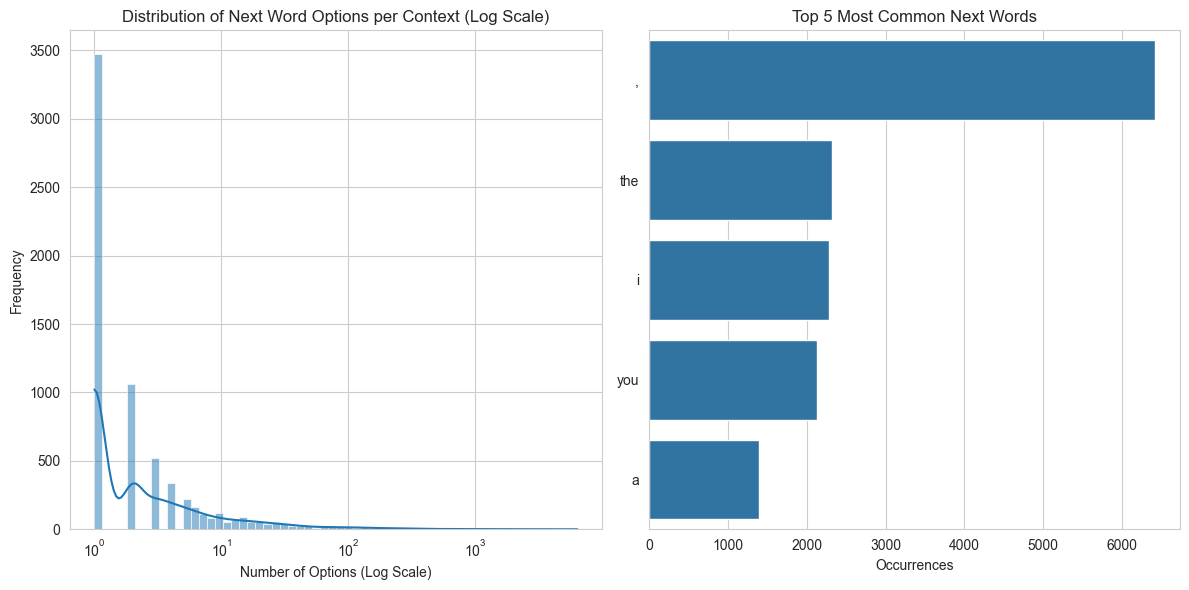

Model Analysis (Order 2):

Total contexts: 32467
Total next words: 71068
Average next words per context: 2.19

Top 5 contexts with most options:
', i' → 162 unique options
', you' → 104 unique options
', im' → 96 unique options
'in the' → 128 unique options
'me ,' → 60 unique options


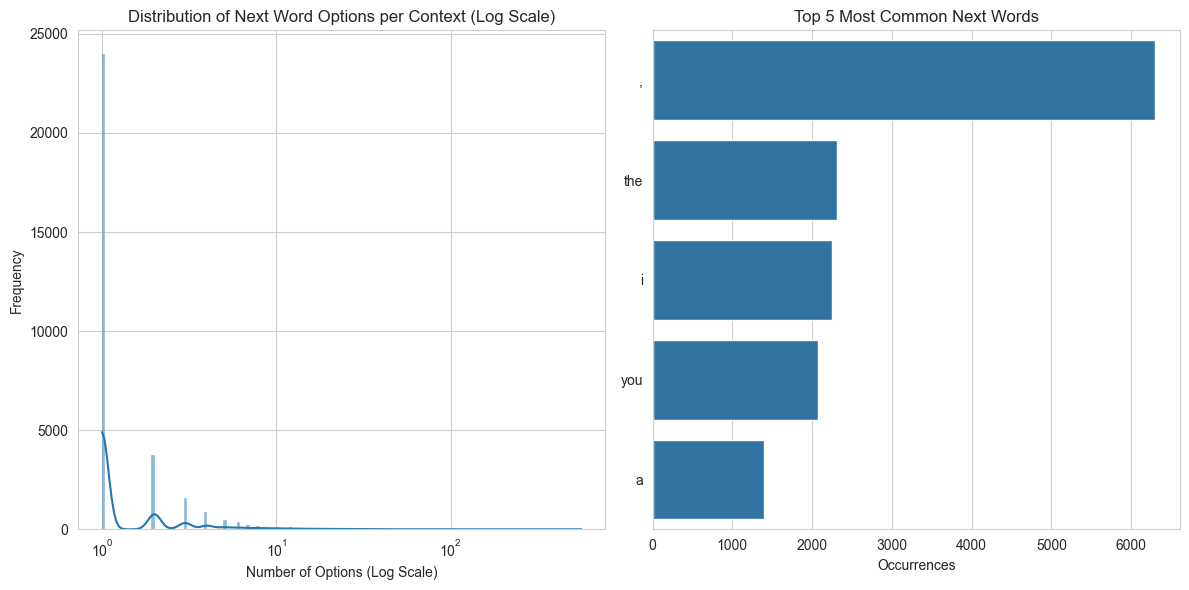

Model Analysis (Order 3):

Total contexts: 50816
Total next words: 70224
Average next words per context: 1.38

Top 5 contexts with most options:
'you might also' → 1 unique options
'might also like' → 58 unique options
'hol up ,' → 6 unique options
'cant please everybody' → 10 unique options
'i cant please' → 2 unique options


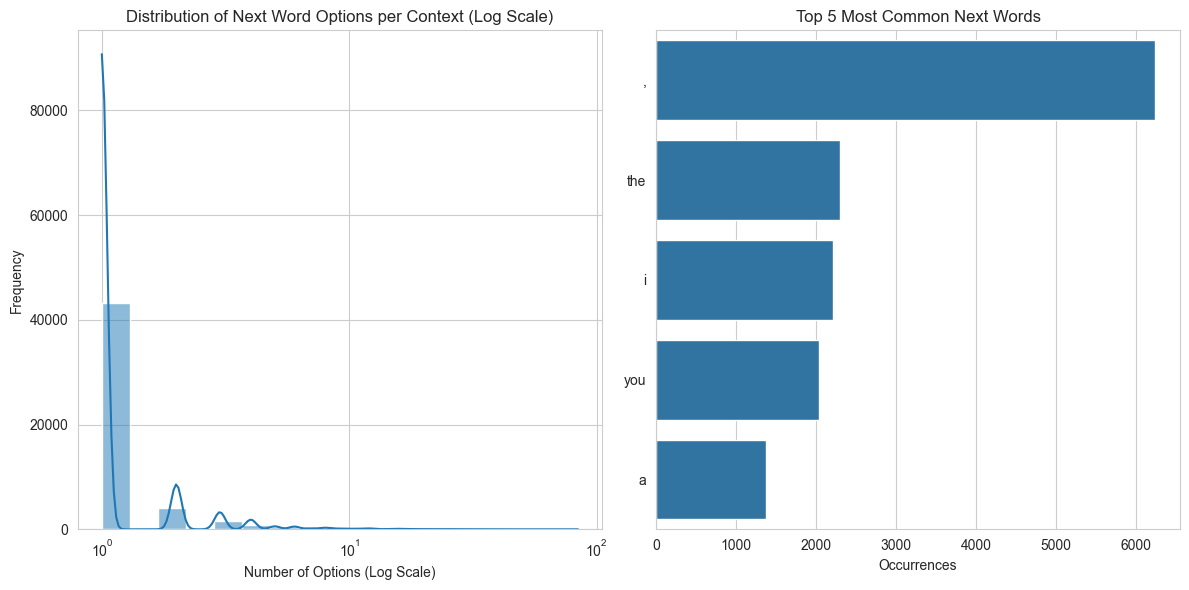

Model Analysis (Order 4):

Total contexts: 55562
Total next words: 69389
Average next words per context: 1.25

Top 5 contexts with most options:
'you might also like' → 58 unique options
'i cant please everybody' → 10 unique options
'hol up , hol' → 1 unique options
'up , hol up' → 7 unique options
'im real , im' → 2 unique options


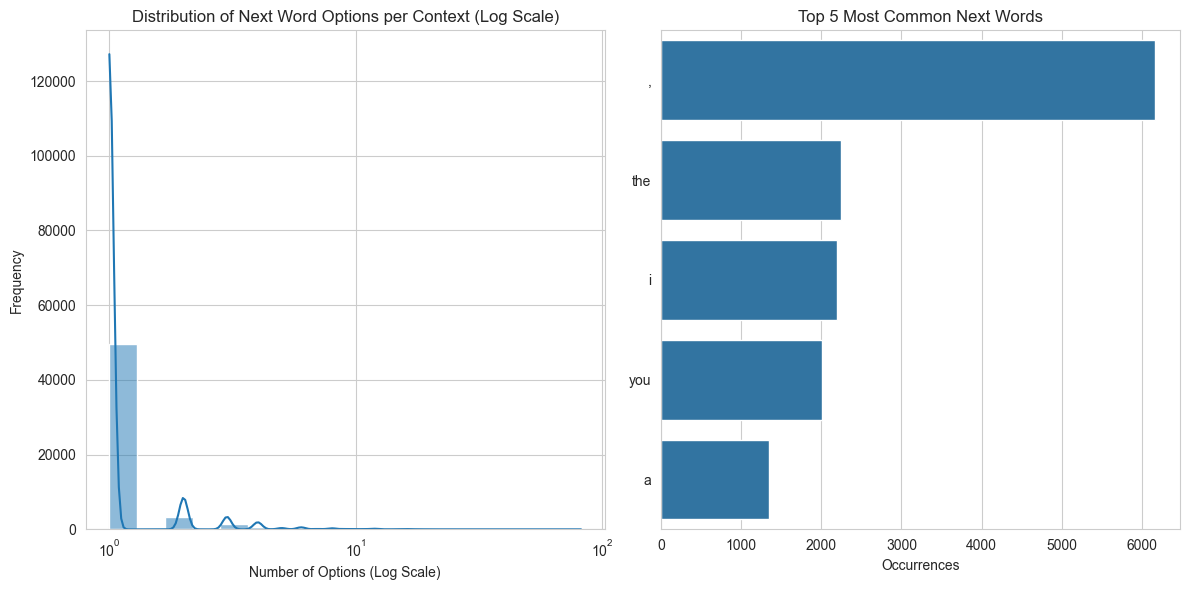

Model Analysis (Order 5):

Total contexts: 56578
Total next words: 68575
Average next words per context: 1.21

Top 5 contexts with most options:
'hol up , hol up' → 7 unique options
'i cant please everybody i' → 1 unique options
'cant please everybody i cant' → 1 unique options
'please everybody i cant please' → 1 unique options
'everybody i cant please everybody' → 5 unique options


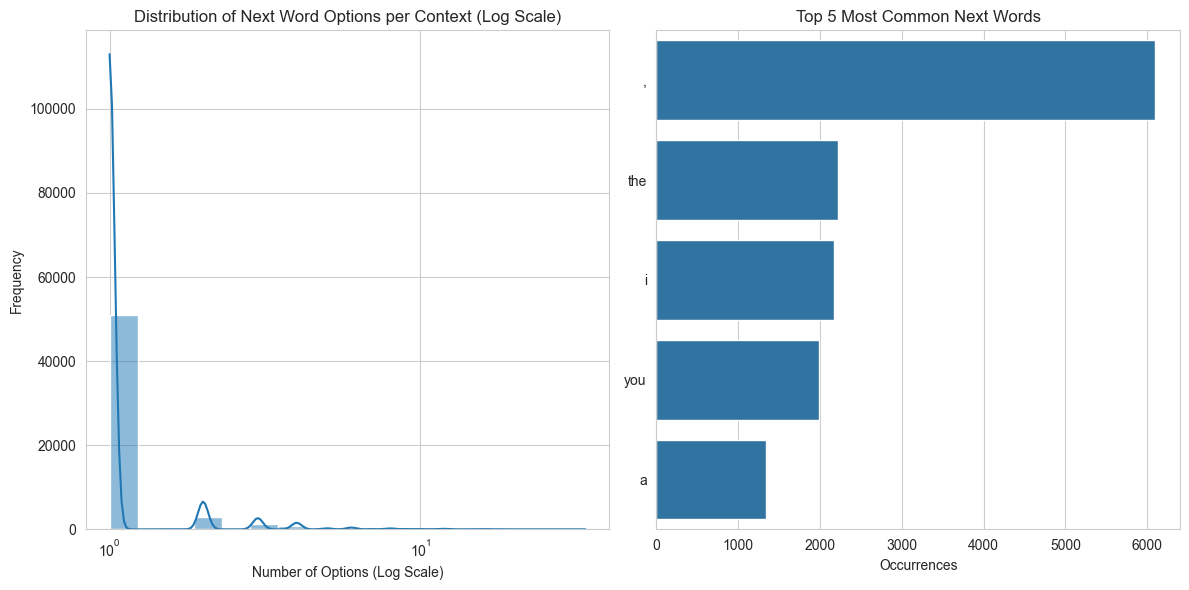

In [62]:
def analyze_model(model):
    """Analyze the Markov model and return insights."""
    if not model.model:
        return "Model is empty."
    
    # Count the number of contexts and next words
    context_count = len(model.model)
    next_word_count = sum(len(nexts) for nexts in model.model.values())
    avg_next_words = next_word_count / context_count
    
    # Find the contexts with the most options
    contexts_by_options = sorted(model.model.items(), key=lambda x: len(x[1]), reverse=True)
    top_contexts = contexts_by_options[:5]
    
    # Find the most common next words overall
    all_next_words = [word for words in model.model.values() for word in words]
    word_counts = {}
    for word in all_next_words:
        word_counts[word] = word_counts.get(word, 0) + 1
    top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    
    # Print the analysis
    print(f"Model Analysis (Order {model.order}):\n")
    print(f"Total contexts: {context_count}")
    print(f"Total next words: {next_word_count}")
    print(f"Average next words per context: {avg_next_words:.2f}")
    
    print("\nTop 5 contexts with most options:")
    for context, next_words in top_contexts:
        print(f"'{' '.join(context)}' → {len(set(next_words))} unique options")
    
    # Create visualizations
    plt.figure(figsize=(12, 6))
    
    # Distribution of next word options
    options_dist = [len(nexts) for nexts in model.model.values()]
    plt.subplot(1, 2, 1)
    # Apply logarithmic scale to the x-axis
    sns.histplot(options_dist, kde=True, log_scale=True) 
    plt.title("Distribution of Next Word Options per Context (Log Scale)")
    plt.xlabel("Number of Options (Log Scale)")
    plt.ylabel("Frequency")
    
    # Top words visualization
    plt.subplot(1, 2, 2)
    top_10_words = dict(top_words[:10])
    sns.barplot(x=list(top_10_words.values()), y=list(top_10_words.keys()))
    plt.title("Top 5 Most Common Next Words")
    plt.xlabel("Occurrences")
    
    plt.tight_layout()
    plt.show()

# Analyze the models if trained
if 'models' in locals() and models:
    for order, model in models.items():
        analyze_model(model)
else:
    print("Models not trained, cannot analyze.")